In [1]:
import pandas as pd
import numpy as np
import math

import time
import datetime

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from transformers import AutoTokenizer, TFAutoModel, AutoConfig, TFBertModel
import tensorflow as tf

import pickle

from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow.keras.backend as K
import math

from datetime import datetime
import string
import warnings


warnings.filterwarnings('ignore')

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
url_test = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/tsd_test.csv"
url_train = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/tsd_train.csv"
url_trial = "https://raw.githubusercontent.com/ipavlopoulos/toxic_spans/master/data/tsd_trial.csv"

train_df = pd.read_csv(url_train, error_bad_lines=False)
test_df = pd.read_csv(url_test, error_bad_lines=False)
trial_df = pd.read_csv(url_trial, error_bad_lines=False)

# Tokenization

In [4]:
import numpy as np

synonyms = ['calumniation', 'insult', 'swearing', 'threat', 'discrimination', 
            'toxic words', 'severe toxic words', 'poisonous words', 
            'severe poisonous words', 'hate speech', 'offensive language', 
            'hatred', 'anger', 'violence', 'abuse', 'rudeness', 
            'profanity', 'cursing', 'intimidation', 'bullying', 
            'oppression', 'menace', 'stereotype', 'sexual harassment', 'hateful words'] 


dicriminations = ['adultism', 'ageism', 'age discrimination',
                  'caste,ableism', 'disablism', 'disability discrimination', 
                  'linguistic discrimination', 'racism', 'racial discrimination', 
                  'discrimination based on skin colour', 'ethnic discrimination', 
                  'racial segregation', 'religious bigotry', 'religious discrimination',
                  'sexism', 'homophobia', 'misogyny', 'misandry', 'transphobia', 
                  'biphobia', 'lookism', 'antisemitism', 'hispanophobia', 
                  'islamophobia', 'sizeism', 'xenophobia', 'chauvinism', 
                  'afrophobia', 'anti-arabism', 'apostasy', 'colourism', 
                  'heightism', 'discrimination against intersex people', 
                  'supremacism', 'genetic discrimination', 'mentalism', 
                  'antisexualism', 'anti-Catholicism'] 

patterns = ['Does the text include toxicity, such as', 
            'Does the text include',
            'Select spans of toxicity in the text, such as', 
            'Find spans of toxicity in the text, such as',
            'Find in the text spans of toxicity, such as']

In [5]:
def get_question(number_words):
    
    pattern = np.random.choice(patterns, 1)[0]
    flag = 'Does' in pattern
    
    toxic_words = set()

    while len(toxic_words) < number_words:
        if np.random.random() > 0.5:
            toxic_words.add(np.random.choice(synonyms, 1)[0])
        else:
            toxic_words.add(np.random.choice(dicriminations, 1)[0])
            
    question = pattern + ' ' + ', '.join(toxic_words) + '?'* flag
    
    return question

In [6]:
class SQuADTokenizedWords:
    
    def __init__(self, model_name, MAX_LEN, shape, decay = 0.9):
        
        self.model_name = model_name
        self.MAX_LEN = MAX_LEN
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, use_fast = False)
        self.shape = shape
        self.decay = decay
        np.random.seed(SEED)
        self.contexts, self.questions, self.answers = self.preprocessing()


    def preprocessing(self):
        
        squad_dev = pd.read_json('https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json')['data'].reset_index()

        contexts = []
        questions = []
        answers = []

        imp_contexts = []
        imp_questions = []
        imp_answers = []

        for instance in squad_dev['data']:
            for paragraph in instance['paragraphs']:
                context = paragraph['context']

                for qas in paragraph['qas']:
                    
                    question = qas['question']
                    if len(context.split()) + len(question.split()) > self.MAX_LEN * self.decay:
                        continue 
                        
                    if qas['is_impossible']:
                        answer = {}
                        imp_contexts.append(context)
                        imp_questions.append(question)
                        answer['ans'] = 'impossible'
                        answer['start_ans'] = -1
                        answer['end_ans'] = -1
                        imp_answers.append(answer)
                        continue


                    for answer in qas['answers']:

                        start = answer['answer_start']

                        end = len(answer['text'])
                        contexts.append(context)
                        questions.append(question)

                        ans = {}
                        ans['ans'] = answer['text']
                        ans['start_ans'] = answer['answer_start']
                        ans['end_ans'] = answer['answer_start'] + len(answer['text']) - 1

                        answers.append(ans)
                        
        shape = self.shape // 2
        
        
        indices = np.random.choice(np.arange(len(contexts)), shape)
        contexts = np.random.choice(contexts, shape, replace = False).tolist()
        questions = np.random.choice(questions, shape, replace = False).tolist()
        answers = np.random.choice(answers, shape, replace = False).tolist()

        
        indices = np.random.choice(np.arange(len(imp_contexts)), shape)
        imp_contexts = np.random.choice(imp_contexts, shape, replace = False).tolist()
        imp_questions = np.random.choice(imp_questions, shape, replace = False).tolist()
        imp_answers = np.random.choice(imp_answers, shape, replace = False).tolist()
        
        contexts +=  imp_contexts
        questions += imp_questions
        answers += imp_answers
        
        np.random.shuffle(contexts)
        np.random.shuffle(questions)
        np.random.shuffle(answers)   
        
        return contexts, questions, answers

    
    def get_params(self):
        self.incorrect_spans = []
        self.incorrect_indexes = []
        all_input_ids = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        attention_masks = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        segment_ids = np.zeros((self.shape, self.MAX_LEN),dtype='int32')

        start_positions = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        end_positions = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        
        num_dropped = 0


        for ex_num, (context, dict_answer, question) in enumerate(zip(self.contexts, self.answers, self.questions)):
            start_char_i, end_char_i, answer = dict_answer['start_ans'], dict_answer['end_ans'],  dict_answer['ans']
            
            if 'roberta-base' == self.model_name or self.model_name == 'roberta-large' : 
                
                context_toks = self.tokenizer.encode(context, add_special_tokens = False )
                question_toks = self.tokenizer.encode(question, add_special_tokens = False)
                
                if answer != 'impossible':
                    context = " " + " ".join(str(context).split())
                    answer = " " + " ".join(str(answer).split())

                    len_st = len(answer) - 1
                    idx0 = None
                    idx1 = None

                    for ind in (i for i, e in enumerate(context) if e == answer[1]):
                        if ' ' + context[ind: ind + len_st] == answer:
                            idx0 = ind
                            idx1 = ind + len_st - 1
                            break

                    char_targets = [0] * len(context)
                    if idx0 != None and idx1 != None:
                        for ct in range(idx0, idx1 + 1):
                            char_targets[ct] = 1

                
                    offsets = []; idx=0
                    for t in context_toks:
                        w = self.tokenizer.decode([t])
                        offsets.append((idx,idx+len(w)))
                        idx += len(w)

                    target_idx = []
                    for j, (offset1, offset2) in enumerate(offsets):
                        if sum(char_targets[offset1: offset2]) > 0:
                            target_idx.append(j)

                    targets_start = target_idx[0]
                    targets_end = target_idx[-1]
                    
                    input_ids = [self.tokenizer.cls_token_id] +  question_toks + \
                            [self.tokenizer.sep_token_id] + [self.tokenizer.sep_token_id] \
                                + context_toks + [self.tokenizer.sep_token_id]
                    token_type_ids = [0] + [0] * len(question_toks) + [0, 0] +  [0] * len(context_toks) + [0]
                    mask = [1] * len(token_type_ids)
                    targets_start =  targets_start + len(question_toks) + 3
                    targets_end = targets_end + len(question_toks) + 3
                else:
                    input_ids = [self.tokenizer.cls_token_id] +  question_toks + \
                            [self.tokenizer.sep_token_id] + [self.tokenizer.sep_token_id] \
                                + context_toks + [self.tokenizer.sep_token_id]
                    token_type_ids = [0] + [0] * len(question_toks) + [0, 0] +  [0] * len(context_toks) + [0]
                    mask = [1] * len(token_type_ids)
                    targets_start = -1
                    targets_end = -1 

                padding_length = self.MAX_LEN - len(input_ids)
                if padding_length > 0:
                    all_input_ids[ex_num, ] = input_ids + ([self.tokenizer.pad_token_id] * padding_length)
                    attention_masks[ex_num, ] = mask + ([0] * padding_length)
                    segment_ids[ex_num, ] = token_type_ids + ([0] * padding_length)
                else:
                    all_input_ids[ex_num, ] = input_ids[:padding_length - 1] + [self.tokenizer.pad_token_id]
                    attention_masks[ex_num, ] = mask[:padding_length-1] + [1]
                    segment_ids[ex_num, ] = token_type_ids[:padding_length-1] + [1]
                    if targets_start >= self.MAX_LEN:
                        targets_start = self.MAX_LEN - 1
                    if targets_end >= self.MAX_LEN:
                        targets_end = self.MAX_LEN - 1
                    
                start_positions[ex_num, targets_start] = 1
                end_positions[ex_num, targets_end] = 1

            else:
                if answer != 'impossible':
                    answer_tokens = self.tokenizer.tokenize(answer)
                    mask_token = self.tokenizer.decode(self.tokenizer.mask_token_id).replace(' ', '')
                    sentinel_str = ' '.join([mask_token]*len(answer_tokens))

                    context_w_sentinel = context[:start_char_i] + sentinel_str + context[end_char_i:]

                    encoded_dict = self.tokenizer.encode_plus(
                                                    question, 
                                                    context_w_sentinel,
                                                    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                                                    max_length = self.MAX_LEN,       # Pad & truncate all sentences.
                                                    pad_to_max_length = True,
                                                    truncation = True,
                                                    return_attention_mask = True,
                                                    return_token_type_ids = True)


                    input_ids = np.array(encoded_dict['input_ids'])

                    mask_token_indeces = np.where(input_ids == self.tokenizer.mask_token_id)[0]

                    if not len(mask_token_indeces) == len(answer_tokens):
                        num_dropped += 1
                        continue


                    start_index = mask_token_indeces[0]
                    end_index = mask_token_indeces[-1]

                    answer_token_ids = self.tokenizer.encode(answer_tokens, add_special_tokens=False )

                    input_ids[start_index : end_index + 1] = answer_token_ids

                    all_input_ids[ex_num, ] = input_ids
                    attention_masks[ex_num, ] = np.array(encoded_dict['attention_mask'])
                    segment_ids[ex_num, ] = np.array(encoded_dict['token_type_ids'])

                    start_positions[ex_num, start_index] = 1
                    end_positions[ex_num, end_index] = 1
                else:
                    encoded_dict = self.tokenizer.encode_plus(
                                                    question, 
                                                    context,
                                                    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                                                    max_length = self.MAX_LEN,       # Pad & truncate all sentences.
                                                    pad_to_max_length = True,
                                                    truncation = True,
                                                    return_attention_mask = True,
                                                    return_token_type_ids = True)
                    
                    all_input_ids[ex_num, ] = np.array(encoded_dict['input_ids'])
                    attention_masks[ex_num, ] = np.array(encoded_dict['attention_mask'])
                    segment_ids[ex_num, ] = np.array(encoded_dict['token_type_ids'])
                    
                    sep_index = np.where(np.array(encoded_dict['input_ids']) == self.tokenizer.sep_token_id)[-1]
                    
                    
                    
                    start_index = sep_index
                    end_index = sep_index

                    start_positions[ex_num, start_index] = 1
                    end_positions[ex_num, end_index] = 1
        
        print(f'The number of dropped examples: {num_dropped}')
                    
                
        return all_input_ids, attention_masks, segment_ids, start_positions, end_positions

In [7]:
class TokenizedWords:
    
    def __init__(self, df, toxic_question, model_name, MAX_LEN, impossible = False, formatted = False, num_words = 10):
        
        self.model_name = model_name
        self.MAX_LEN = MAX_LEN
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, use_fast = False)
        self.impossible = impossible
        self.formatted = formatted
        self.df = df

        self.contexts, self.answers, self.number_of_toxic_words = self.preprocessing(df)
            
        self.shape = len(self.contexts)
        
        if toxic_question == None:
            np.random.seed(SEED)
            self.questions = [get_question(num_words)  for _ in range(self.shape)]
        else:
            self.questions = [toxic_question] * self.shape
        
        
    def text_cleaning(self, text):
        punc = ("'", ",", ".", "?", "!", '"')
        text = text.replace('\n', ' ')
        for p in punc:
            text = text.replace(p , ' ' + p + ' ')

        for space in range(2, 5):
            text = text.replace(' '*space, ' ')
        return text
       
    def preprocessing(self, df: pd.DataFrame,):
        contexts = []
        answers = []
        number_of_toxic_words = []
        num_imp = 0

        for i in range(len(df)):
        
            text_str = df['spans'][i]
            splitted_str = text_str[1:-1].split(", ")

            if len(splitted_str) == 1:
                if self.impossible:
                    #pad_token = self.tokenizer.decode(self.tokenizer.pad_token_id).replace(' ', '')
                    contexts.append(df['text'][i])
                    answers.append({"start_ans": -1, "end_ans": -1, 'ans': 'impossible'})
                    num_imp += 1
                continue

            
            splitted_str = list(map(int, splitted_str))

            context = df['text'][i]

            gaps = [[s, e] for s, e in zip(splitted_str, splitted_str[1:]) if s + 1 < e]
            edges = iter(splitted_str[:1] + sum(gaps, []) + splitted_str[-1:])
            unformatted_answers = list(zip(edges, edges))
            
            toxic_words = [context[tokens[0]:tokens[1] + 1] for tokens in unformatted_answers]
            formatted_toxic_words = [self.text_cleaning(toxic_word) for toxic_word in toxic_words]

            cleaned_context = self.text_cleaning(context)

            indices = [(cleaned_context.index(toxic_word), cleaned_context.index(toxic_word) + len(toxic_word))
                        for toxic_word in formatted_toxic_words]


            for tokens, new_tokens in zip(unformatted_answers, indices):
                start_token, end_token = tokens[0], tokens[1]
                new_start_token, new_end_token = new_tokens[0], new_tokens[1]

                answer = {}
                if self.formatted:
                    answer["start_ans"] = new_start_token
                    answer["end_ans"] = new_end_token + 1
                    answer['ans'] = self.text_cleaning(cleaned_context[new_start_token: new_end_token])
                    contexts.append(cleaned_context) 
                    answers.append(answer)
                else:
                    answer["start_ans"] = start_token
                    answer["end_ans"] = end_token + 1
                    answer['ans'] = context[start_token:end_token+1]
                    contexts.append(context)
                    answers.append(answer)
                    
            number_of_toxic_words.append(len(unformatted_answers))
                
        print(f"Number impossible: {num_imp}")
        return contexts, answers, number_of_toxic_words 

    
    def get_params(self):
        self.incorrect_spans = []
        self.incorrect_indexes = []
        all_input_ids = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        attention_masks = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        segment_ids = np.zeros((self.shape, self.MAX_LEN),dtype='int32')

        start_positions = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        end_positions = np.zeros((self.shape, self.MAX_LEN),dtype='int32')
        
        num_dropped = 0


        for ex_num, (context, dict_answer, question) in enumerate(zip(self.contexts, self.answers, self.questions)):
            start_char_i, end_char_i, answer = dict_answer['start_ans'], dict_answer['end_ans'],  dict_answer['ans']
            
            if 'roberta-base' == self.model_name or self.model_name == 'roberta-large' : 
                
                context_toks = self.tokenizer.encode(context, add_special_tokens = False )
                question_toks = self.tokenizer.encode(question, add_special_tokens = False)
                
                if answer != 'impossible':
                    context = " " + " ".join(str(context).split())
                    answer = " " + " ".join(str(answer).split())


                    len_st = len(answer) - 1
                    idx0 = None
                    idx1 = None

                    for ind in (i for i, e in enumerate(context) if e == answer[1]):
                        if ' ' + context[ind: ind + len_st] == answer:
                            idx0 = ind
                            idx1 = ind + len_st - 1
                            break

                    char_targets = [0] * len(context)
                    if idx0 != None and idx1 != None:
                        for ct in range(idx0, idx1 + 1):
                            char_targets[ct] = 1

                
                    offsets = []; idx=0
                    for t in context_toks:
                        w = self.tokenizer.decode([t])
                        offsets.append((idx,idx+len(w)))
                        idx += len(w)

                    target_idx = []
                    for j, (offset1, offset2) in enumerate(offsets):
                        if sum(char_targets[offset1: offset2]) > 0:
                            target_idx.append(j)

                    targets_start = target_idx[0]
                    targets_end = target_idx[-1]
                    
                    input_ids = [self.tokenizer.cls_token_id] +  question_toks + \
                            [self.tokenizer.sep_token_id] + [self.tokenizer.sep_token_id] \
                                + context_toks + [self.tokenizer.sep_token_id]
                    token_type_ids = [0] + [0] * len(question_toks) + [0, 0] +  [0] * len(context_toks) + [0]
                    mask = [1] * len(token_type_ids)
                    targets_start =  targets_start + len(question_toks) + 3
                    targets_end = targets_end + len(question_toks) + 3
                else:
                    input_ids = [self.tokenizer.cls_token_id] +  question_toks + \
                            [self.tokenizer.sep_token_id] + [self.tokenizer.sep_token_id] \
                                + context_toks + [self.tokenizer.sep_token_id]
                    token_type_ids = [0] + [0] * len(question_toks) + [0, 0] +  [0] * len(context_toks) + [0]
                    mask = [1] * len(token_type_ids)
                    targets_start = -1
                    targets_end = -1 
                    
                

                padding_length = self.MAX_LEN - len(input_ids)
                if padding_length > 0:
                    all_input_ids[ex_num, ] = input_ids + ([self.tokenizer.pad_token_id] * padding_length)
                    attention_masks[ex_num, ] = mask + ([0] * padding_length)
                    segment_ids[ex_num, ] = token_type_ids + ([0] * padding_length)
                else:
                    all_input_ids[ex_num, ] = input_ids[:padding_length - 1] + [self.tokenizer.pad_token_id]
                    attention_masks[ex_num, ] = mask[:padding_length-1] + [1]
                    segment_ids[ex_num, ] = token_type_ids[:padding_length-1] + [1]
                    if targets_start >= self.MAX_LEN:
                        targets_start = self.MAX_LEN - 1
                    if targets_end >= self.MAX_LEN:
                        targets_end = self.MAX_LEN - 1
                    
                start_positions[ex_num, targets_start] = 1
                end_positions[ex_num, targets_end] = 1

            else:
                if answer != 'impossible':
                    answer_tokens = self.tokenizer.tokenize(answer)
                    mask_token = self.tokenizer.decode(self.tokenizer.mask_token_id).replace(' ', '')
                    sentinel_str = ' '.join([mask_token]*len(answer_tokens))

                    context_w_sentinel = context[:start_char_i] + sentinel_str + context[end_char_i:]

                    encoded_dict = self.tokenizer.encode_plus(
                                                    question, 
                                                    context_w_sentinel,
                                                    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                                                    max_length = self.MAX_LEN,       # Pad & truncate all sentences.
                                                    pad_to_max_length = True,
                                                    truncation = True,
                                                    return_attention_mask = True,
                                                    return_token_type_ids = True)


                    input_ids = np.array(encoded_dict['input_ids'])

                    mask_token_indeces = np.where(input_ids == self.tokenizer.mask_token_id)[0]

                    if not len(mask_token_indeces) == len(answer_tokens):
                        num_dropped += 1
                        continue


                    start_index = mask_token_indeces[0]
                    end_index = mask_token_indeces[-1]

                    answer_token_ids = self.tokenizer.encode(answer_tokens, add_special_tokens=False )

                    input_ids[start_index : end_index + 1] = answer_token_ids

                    all_input_ids[ex_num, ] = input_ids
                    attention_masks[ex_num, ] = np.array(encoded_dict['attention_mask'])
                    segment_ids[ex_num, ] = np.array(encoded_dict['token_type_ids'])

                    start_positions[ex_num, start_index] = 1
                    end_positions[ex_num, end_index] = 1
                else:
                    encoded_dict = self.tokenizer.encode_plus(
                                                    question, 
                                                    context,
                                                    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                                                    max_length = self.MAX_LEN,       # Pad & truncate all sentences.
                                                    pad_to_max_length = True,
                                                    truncation = True,
                                                    return_attention_mask = True,
                                                    return_token_type_ids = True)
                    
                    all_input_ids[ex_num, ] = np.array(encoded_dict['input_ids'])
                    attention_masks[ex_num, ] = np.array(encoded_dict['attention_mask'])
                    segment_ids[ex_num, ] = np.array(encoded_dict['token_type_ids'])
                    
                    sep_index = np.where(np.array(encoded_dict['input_ids']) == self.tokenizer.sep_token_id)[-1]
                    
                    
                    
                    start_index = sep_index#-1
                    end_index = sep_index#-1

                    start_positions[ex_num, start_index] = 1
                    end_positions[ex_num, end_index] = 1
        
        print(f'The number of dropped examples: {num_dropped}')
                    
                
        return all_input_ids, attention_masks, segment_ids, start_positions, end_positions

# Model

In [8]:
def jaccard_score(pred, true): 
    pred_tokens = set(pred.lower().split())
    true_tokens = set(true.lower().split())
    if (len(pred_tokens)==0) & (len(true_tokens)==0): 
        return 0.5
    inter_tokens = pred_tokens.intersection(true_tokens)
    return float(len(inter_tokens)) / (len(pred_tokens) + len(true_tokens) - len(inter_tokens))


def f1_score(pred, true):
    pred_tokens = pred.lower().split()
    true_tokens = true.lower().split()

    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return int(pred_tokens == true_tokens) 

    common_tokens = set(pred_tokens) & set(true_tokens)

    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(true_tokens)

    return 2 * (prec * rec) / (prec + rec)

In [9]:
 class TfModel:
        
    def __init__(self, model_name, train_params, val_params, test_params, MAX_LEN, prefit = False):
        
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True, use_fast = False)
        self.MAX_LEN = MAX_LEN
        self.prefit = prefit
        
        self.all_input_ids, self.attention_masks, self.segment_ids, self.start_positions, self.end_positions = train_params
        self.all_input_ids_v, self.attention_masks_v, self.segment_ids_v, self.start_positions_v, self.end_positions_v = val_params
        self.all_input_ids_t, self.attention_masks_t, self.segment_ids_t, self.start_positions_t, self.end_positions_t = test_params
        
        self.train_dataset_len = self.all_input_ids.shape[0]
        self.valid_dataset_len = self.all_input_ids_v.shape[0]
        self.test_dataset_len = self.all_input_ids_t.shape[0]
        
        self.n_steps = self.train_dataset_len // BATCH_SIZE
        self.n_val_steps = self.valid_dataset_len // BATCH_SIZE
        
        #valid
        self.oof_start = np.zeros((self.train_dataset_len, self.MAX_LEN))
        self.oof_end = np.zeros((self.train_dataset_len, self.MAX_LEN))
        
        
        #train
        self.preds_start_train = np.zeros((self.train_dataset_len, self.MAX_LEN))
        self.preds_end_train = np.zeros((self.train_dataset_len, self.MAX_LEN))
        
        #test
        self.preds_start = np.zeros((self.test_dataset_len, self.MAX_LEN))
        self.preds_end = np.zeros((self.test_dataset_len, self.MAX_LEN))
              
    
    def save_weights(self, model, dst_fn):
        weights = model.get_weights()
        with open(dst_fn, 'wb') as f:
            pickle.dump(weights, f)

    def load_weights(self, model, weight_fn):
        with open(weight_fn, 'rb') as f:
            weights = pickle.load(f)
        model.set_weights(weights)
        return model
    
    def loss_fn(self, y_true, y_pred):
        # adjust the targets for sequence bucketing
        ll = tf.shape(y_pred)[1]
        y_true = y_true[:, :ll]
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False, label_smoothing=LABEL_SMOOTHING)
        loss = tf.reduce_mean(loss)
        return loss


    def build_model(self, transformer_layer):
        ids = tf.keras.layers.Input((self.MAX_LEN,), dtype=tf.int32, name = 'input_1')
        att = tf.keras.layers.Input((self.MAX_LEN,), dtype=tf.int32, name = 'input_2')
        tok = tf.keras.layers.Input((self.MAX_LEN,), dtype=tf.int32, name = 'input_3')
        padding = tf.cast(tf.equal(ids, self.tokenizer.pad_token_id), tf.int32)

        lens = self.MAX_LEN - tf.reduce_sum(padding, -1)
        max_len = tf.reduce_max(lens)
        ids_ = ids[:, :max_len]
        att_ = att[:, :max_len]
        tok_ = tok[:, :max_len]

        #config = AutoConfig.from_pretrained(model_name)
        #bert_model = TFAutoModel.from_pretrained(model_name,config=config)
        x = transformer_layer(ids_,attention_mask=att_,token_type_ids=tok_)

        x1 = tf.keras.layers.Dropout(Dropout_new)(x[0])
        x1 = tf.keras.layers.Conv1D(768, 2,padding='same')(x1)
        x1 = tf.keras.layers.LeakyReLU()(x1)
        x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
        x1 = tf.keras.layers.Dense(1)(x1)
        x1 = tf.keras.layers.Flatten()(x1)
        x1 = tf.keras.layers.Activation('softmax', name='output_1')(x1)

        x2 = tf.keras.layers.Dropout(Dropout_new)(x[0]) 
        x2 = tf.keras.layers.Conv1D(768, 2,padding='same')(x2)
        x2 = tf.keras.layers.LeakyReLU()(x2)
        x2 = tf.keras.layers.Conv1D(64, 2, padding='same')(x2)
        x2 = tf.keras.layers.Dense(1)(x2)
        x2 = tf.keras.layers.Flatten()(x2)
        x2 = tf.keras.layers.Activation('softmax', name='output_2')(x2)

        model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr) 
        model.compile(loss= self.loss_fn, optimizer=optimizer)

        # this is required as `model.predict` needs a fixed size!
        x1_padded = tf.pad(x1, [[0, 0], [0, self.MAX_LEN - max_len]], constant_values=0.)
        x2_padded = tf.pad(x2, [[0, 0], [0, self.MAX_LEN - max_len]], constant_values=0.)

        padded_model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1_padded,x2_padded])
        return model, padded_model
    
    
    def get_train_dataset(self):
        dataset = (
                tf.data.Dataset
                .from_tensor_slices(({"input_1": self.all_input_ids, 
                                      "input_2": self.attention_masks, 
                                      "input_3": self.segment_ids}, 
                                     {"output_1": self.start_positions, 
                                      "output_2": self.end_positions}))
                .repeat()
                .shuffle(2048)
                .batch(BATCH_SIZE)
                .prefetch(AUTO)
            )
        
        return dataset
    
    def get_valid_dataset(self):
        valid_dataset = (
                tf.data.Dataset
                 .from_tensor_slices(({"input_1": self.all_input_ids_v, 
                                      "input_2": self.attention_masks_v, 
                                      "input_3": self.segment_ids_v}, 
                                     {"output_1": self.start_positions_v, 
                                      "output_2": self.end_positions_v}))
                .batch(BATCH_SIZE)
                .cache()
                .prefetch(AUTO)
            )
        
        return valid_dataset
    
    def get_squad_dataset(self):
        shape = self.train_dataset_len // 4
        print('SQuAD dataset len : ', shape)
        print(' ')
        
        squad_tokenizer = SQuADTokenizedWords(self.model_name, self.MAX_LEN, shape, decay = 0.9)
        inputs, attentions, segments, starts, ends = squad_tokenizer.get_params()
        
        squad_dataset = (
                tf.data.Dataset
                .from_tensor_slices(({"input_1": inputs, 
                                      "input_2": attentions, 
                                      "input_3": segments}, 
                                     {"output_1": starts, 
                                      "output_2": ends}))
                .repeat()
                .shuffle(2048)
                .batch(BATCH_SIZE)
                .prefetch(AUTO)
            )
        
        return squad_dataset
        
        
    
    def save_predictions(self, predictions, answers, contexts, jac_scores, f1_scores, prefix, start_idx, end_idx):
        
        true_answers = [ans['ans'] for ans in answers]
        true_start = [ans['start_ans'] for ans in answers]
        true_end = [ans['end_ans'] for ans in answers]
        predictions_csv = pd.DataFrame({"predictions": predictions, "true_answers": true_answers, \
                                    'train_contexts': contexts, "jac_scores": jac_scores, \
                                    "f1_scores": f1_scores, 'start_pred_idx': start_idx, 'end_pred_idx': end_idx, \
                                    'true_start': true_start, 'true_end': true_end})
        
        predictions_csv.to_csv(f"{prefix}_{self.model_name.replace('/', '_')}_predictions.csv", index = False)
        
        
    
    def fit(self):
        K.clear_session()

        train_dataset = self.get_train_dataset()
        valid_dataset = self.get_valid_dataset()

        with strategy.scope():
            if self.model_name == 'SpanBERT/spanbert-base-cased' or  self.model_name == 'SpanBERT/spanbert-large-cased':
                transformer_layer = TFBertModel.from_pretrained(self.model_name, config=self.config, from_pt = True)
            else:
                transformer_layer = TFAutoModel.from_pretrained(self.model_name, config=self.config)
            model, padded_model = self.build_model(transformer_layer)
            
        if prefit:
            
            squad_dataset = self.get_squad_dataset()
            print("Fit squad_data_set", sep = '\n')
            
            model.fit(
            squad_dataset,
            steps_per_epoch = self.n_steps // 4,
            batch_size = BATCH_SIZE,
            epochs = EPOCHS, 
            shuffle = False
        )
            
        print("Fit train_data_set", sep = '\n')

        model.fit(
            train_dataset,
            steps_per_epoch = self.n_steps,
            batch_size= BATCH_SIZE,
            validation_data = valid_dataset,
            epochs = EPOCHS, 
            shuffle = False
        )

        
        self.oof_start, self.oof_end = padded_model.predict([self.all_input_ids_v, self.attention_masks_v, \
                                                                 self.segment_ids_v], verbose=DISPLAY)
        
        val_predictions, val_jac_scores, val_f1_scores, val_st_idx, val_e_idx = self.predict(self.oof_start, self.oof_end, \
                                                val_contexts, val_questions, val_answers)
        
        self.save_predictions(val_predictions, val_answers, val_contexts, val_jac_scores, val_f1_scores, 'valid', val_st_idx, val_e_idx)
        
        print('>>>> VALID Jaccard =',  np.round(np.mean(val_jac_scores), 3))
        print('>>>> VALID F1-score =',  np.round(np.mean(val_f1_scores), 3))
        print('*****'*4)
        
       
        preds_train = padded_model.predict([self.all_input_ids, self.attention_masks, self.segment_ids], verbose=DISPLAY)
        
        self.preds_start_train += preds_train[0]
        self.preds_end_train += preds_train[1]
        
        train_predictions, train_jac_scores, train_f1_scores, tr_st_idx, tr_e_idx = self.predict(self.preds_start_train, self.preds_end_train, \
                                                train_contexts, train_questions, train_answers)
        
        self.save_predictions(train_predictions, train_answers, train_contexts, train_jac_scores, train_f1_scores, 'train', tr_st_idx, tr_e_idx)
        
        print('>>>> TRAIN Jaccard =', np.round(np.mean(train_jac_scores), 3))
        print('>>>> TRAIN F1-score =',  np.round(np.mean(train_f1_scores), 3))
        print('>>>>'*4)


        print("Fit val_data_set", sep = '\n')
        model.fit(
            valid_dataset.repeat(),
            steps_per_epoch = self.n_val_steps,
            batch_size = BATCH_SIZE,
            epochs = EPOCHS // 2, 
            shuffle = False
        )
        
        weight_fn = f'{model_name}.h5'.replace('/', '_') #,'%s-roberta-%i.h5'%(VER,fold)
        self.save_weights(model, weight_fn)

        print('Predicting Test...')
        preds = padded_model.predict([self.all_input_ids_t, self.attention_masks_t, self.segment_ids_t],verbose=DISPLAY)
        self.preds_start += preds[0]
        self.preds_end += preds[1]
        
        test_predictions, test_jac_scores, test_f1_scores, t_st_idx, t_e_idx = self.predict(self.preds_start, self.preds_end, \
                                                test_contexts, test_questions, test_answers)
        
        self.save_predictions(test_predictions, test_answers, test_contexts, test_jac_scores, test_f1_scores, 'test', t_st_idx, t_e_idx)
        
        print('>>>> TEST Jaccard =', np.round(np.mean(test_jac_scores), 3))
        print('>>>> TEST F1-score =', np.round(np.mean(test_f1_scores), 3))
        print('>>>>'*4)

            
    def predict(self, start, end, contexts, questions, answers):
        idx = np.arange(len(contexts))
        predictions, jac_scores, f1_scores, start_idx, end_idx  = [], [], [], [], []

        
        for k in idx:
            start_pred_token = np.argmax(start[k,])
            end_pred_token = np.argmax(end[k,]) + 1
            
            if start_pred_token > end_pred_token: 
                start_pred_token, end_pred_token = end_pred_token, start_pred_token
                st = contexts[k] # IMPROVE CV/LB with better choice here
            elif self.model_name == 'roberta-base' or self.model_name == 'roberta-large':
                
                context_toks = self.tokenizer.encode(contexts[k], add_special_tokens = False )
                question_toks = self.tokenizer.encode(questions[k], add_special_tokens = False)
                
                input_ids = [self.tokenizer.cls_token_id] +  question_toks + \
                            [self.tokenizer.sep_token_id] + [self.tokenizer.sep_token_id] \
                                + context_toks + [self.tokenizer.sep_token_id]
                
                padding_length = self.MAX_LEN - len(input_ids)
                if padding_length > 0:
                    input_ids = input_ids + ([self.tokenizer.pad_token_id] * padding_length)
                else:
                    input_ids = input_ids[:padding_length - 1] + [self.tokenizer.pad_token_id]
                    
                st = self.tokenizer.decode(input_ids[start_pred_token:end_pred_token-1])
            else:
                encoded_dict = self.tokenizer.encode_plus(
                    questions[k], 
                    contexts[k],
                    add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                    max_length = self.MAX_LEN,       # Pad & truncate all sentences.
                    pad_to_max_length = True,
                    truncation = True,
                    return_attention_mask = True, # Construct attention masks.
                    )

                enc = np.array(encoded_dict['input_ids'])
                st = self.tokenizer.decode(enc[start_pred_token:end_pred_token])

            jaccard_sc = jaccard_score(st, answers[k]['ans'])
            f1_sc = f1_score(st, answers[k]['ans'])

            jac_scores.append(jaccard_sc)
            f1_scores.append(f1_sc)
            predictions.append(st)
            start_idx.append(start_pred_token)
            end_idx.append(end_pred_token)
            
        
        return predictions, jac_scores, f1_scores, start_idx, end_idx

# Settings

In [10]:
DISPLAY = 2
MAX_LEN = 256
EPOCHS = 3 # originally 3
BATCH_SIZE = 8 # originally 3
SEED = 88888

LABEL_SMOOTHING = 0.1
tf.random.set_seed(SEED)
np.random.seed(SEED)
AUTO = tf.data.experimental.AUTOTUNE

Dropout_new = 0.2    # originally 0.1
n_split = 2         # originally 5
lr = 5e-6           # originally 3e-5

In [11]:
toxic_question = None

all_model_names = ['bert-base-cased', 'bert-large-cased',
                  'roberta-base', 'roberta-large',
                  'albert-base-v2', 'albert-large-v2', 'albert-xlarge-v2', 'albert-xxlarge-v2', 
                  "jplu/tf-xlm-roberta-base", "jplu/tf-xlm-roberta-large",
                   'SpanBERT/spanbert-base-cased', 'SpanBERT/spanbert-large-cased']
model_names = ['albert-xxlarge-v2',  ]#'bert-large-cased',]#"jplu/tf-xlm-roberta-base",]#,  


#model_names = [  "jplu/tf-xlm-roberta-base", "jplu/tf-xlm-roberta-large" ]#[ "jplu/tf-xlm-roberta-large", "jplu/tf-xlm-roberta-base",  ]

In [12]:
size = len(train_df)
np.random.seed(SEED)
random_samples = np.random.choice(np.arange(len(train_df)), size)
copy_df = train_df.loc[random_samples]
copy_df.index = np.arange(size)

copy_trial_df = trial_df
copy_test_df = test_df

In [13]:
formatted = False
impossible = True
prefit = True
num_words = 10

for model_name in model_names:
    if 'large' in model_name:
        BATCH_SIZE = 3
        
    start_time = datetime.now()
    print(f"{model_name} start processing")
    print("\n")
    
    train_token = TokenizedWords(copy_df, toxic_question, model_name, MAX_LEN,  impossible = impossible, formatted = formatted, num_words = num_words)
    all_input_ids, attention_masks, segment_ids, start_positions, end_positions = train_token.get_params()
    train_contexts, train_questions, train_answers = train_token.contexts, train_token.questions, train_token.answers
    
    train_params = (all_input_ids, attention_masks, segment_ids, start_positions, end_positions)
    print("Train params processing finished")
    print(' ')
    
    val_token = TokenizedWords(copy_trial_df, toxic_question, model_name, MAX_LEN,  impossible = impossible, formatted = formatted, num_words = num_words)
    all_input_ids_v, attention_masks_v, segment_ids_v, start_positions_v, end_positions_v = val_token.get_params()
    val_contexts, val_questions, val_answers = val_token.contexts, val_token.questions, val_token.answers

    val_params = (all_input_ids_v, attention_masks_v, segment_ids_v, start_positions_v, end_positions_v)
    print("Valid params processing finished")
    print(' ')
    
    test_token = TokenizedWords(copy_test_df, toxic_question, model_name, MAX_LEN,  impossible = impossible, formatted = formatted, num_words = num_words)
    all_input_ids_t, attention_masks_t, segment_ids_t, start_positions_t, end_positions_t = test_token.get_params()
    test_contexts, test_questions, test_answers = test_token.contexts, test_token.questions, test_token.answers
    
    test_params = (all_input_ids_t, attention_masks_t, segment_ids_t, start_positions_t, end_positions_t)
    print("Test params processing finished")
    print(' ')

    print("Fit process has started")
    tf_model = TfModel(model_name, train_params, val_params, test_params, MAX_LEN, prefit)
    tf_model.fit()
    print("Fit process has finished")

    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    print(" "*25)

albert-xxlarge-v2 start processing




Downloading:   0%|          | 0.00/710 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Number impossible: 486
The number of dropped examples: 44
Train params processing finished
 
Number impossible: 43
The number of dropped examples: 2
Valid params processing finished
 
Number impossible: 394
The number of dropped examples: 1
Test params processing finished
 
Fit process has started


Downloading:   0%|          | 0.00/908M [00:00<?, ?B/s]

Some layers from the model checkpoint at albert-xxlarge-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-xxlarge-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


SQuAD dataset len :  2708
 
The number of dropped examples: 0
Fit squad_data_set
Epoch 1/3
902/902 [==============================] - 1351s 1s/step - loss: 13.4869 - output_1_loss: 6.7848 - output_2_loss: 6.7021
Epoch 2/3
902/902 [==============================] - 1327s 1s/step - loss: 168.4659 - output_1_loss: 85.1596 - output_2_loss: 83.3062
Epoch 3/3
902/902 [==============================] - 1323s 1s/step - loss: 620.4784 - output_1_loss: 314.5748 - output_2_loss: 305.9035
Fit train_data_set
Epoch 1/3
3610/3610 [==============================] - 3758s 1s/step - loss: 206.9750 - output_1_loss: 106.3579 - output_2_loss: 100.6171 - val_loss: 210.9800 - val_output_1_loss: 108.3746 - val_output_2_loss: 102.6054
Epoch 2/3
3610/3610 [==============================] - 3724s 1s/step - loss: 292.3774 - output_1_loss: 149.7990 - output_2_loss: 142.5785 - val_loss: 310.5785 - val_output_1_loss: 160.0651 - val_output_2_loss: 150.5134
Epoch 3/3
3610/3610 [==============================] - 3760s 

In [14]:
pattern = f"test_{model_name.replace('/', '_')}_predictions.csv"
predictions_csv = pd.read_csv(pattern)

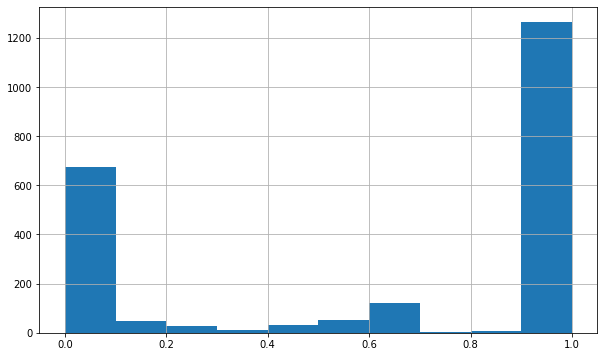

In [15]:
predictions_csv.f1_scores.hist(figsize = (10, 6), );#.mean()

In [16]:
predictions_csv[150:170]#.f1_scores.mean()

,predictions,true_answers,train_contexts,jac_scores,f1_scores,start_pred_idx,end_pred_idx,true_start,true_end
150,jerk,jerk,"Crawl in a hole and die, jerk. And before anyb...",1.0,1.000000,46,47,25,29
151,foolish,foolish,"Wow, Lisa Ho looks foolish.",1.0,1.000000,45,46,19,26
152,liar,liar,"Why do you think liar, thief and evil, foul-m...",1.0,1.000000,42,43,18,22
153,foul-mouthed,foul-mouthed,"Why do you think liar, thief and evil, foul-m...",1.0,1.000000,47,50,40,52
154,pathetic,pathetic,You're pathetic. You voted for Trump because ...,1.0,1.000000,46,47,7,15
155,up nerd,nerd,Shut up nerd. You try too hard.,0.5,0.666667,47,49,8,12
156,dumbest,dumbest,You’re is one of the dumbest comments I’ve eve...,1.0,1.000000,60,62,21,28
157,sick f**ks,f**ks,Sick f**ks like this should just be shot. Wha...,0.5,0.666667,46,50,5,10
158,idiot,idiot,This guy is an idiot. He was all in for shorti...,1.0,1.000000,37,38,15,20
159,stupid,stupid,"there are sick delusional people and liars, an...",1.0,1.000000,62,63,108,114


In [17]:
# ЧТО можно сделать еще: показать распределение токсичных слов в каждом тексте. 
# Сколько текстов не используется при обучении с impossible questions
